In [40]:
import multibandphotometry as mbp
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.visualization import ZScaleInterval, ImageNormalize, make_lupton_rgb
from photutils.aperture import SkyEllipticalAperture, SkyCircularAperture


In [3]:
source_position = SkyCoord(150.15949, 2.1914772, frame='icrs', unit=u.deg)
z = 0.924
phot = mbp.MultiBandPhotometry(source_position, z, psf_homo='F444W')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set DATE-END to '2016-06-04T00:47:19.488' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-05-03T03:37:16.477' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-06-29T23:52:46.677' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-05-03T03:02:47.823' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-04-30T03:11:04.794' from MJD-END'. [astropy.wcs.wcs]


# RGB image with nebular contours

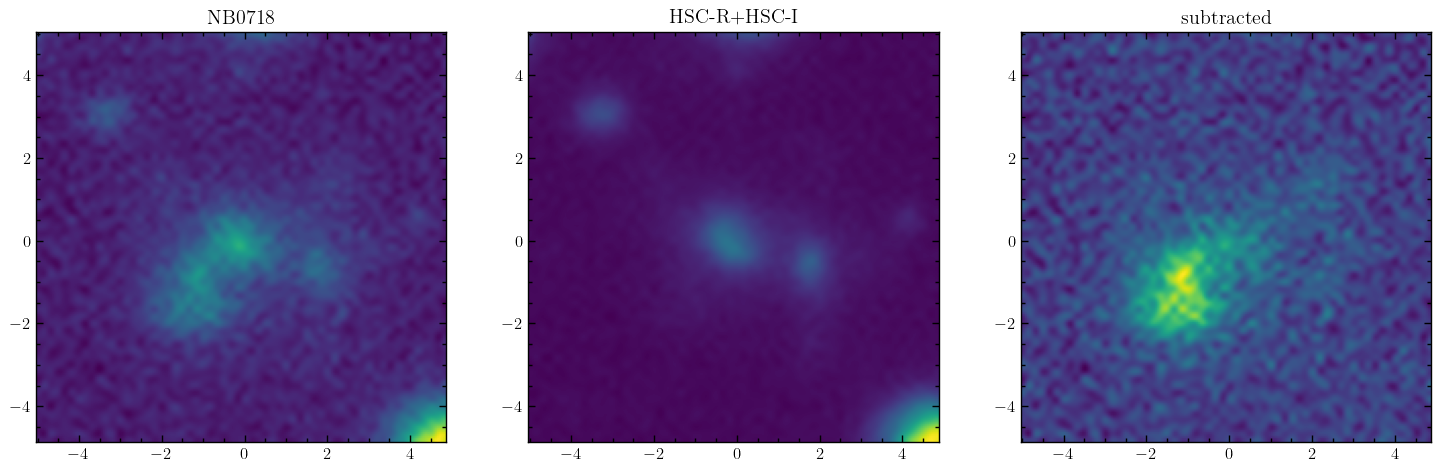

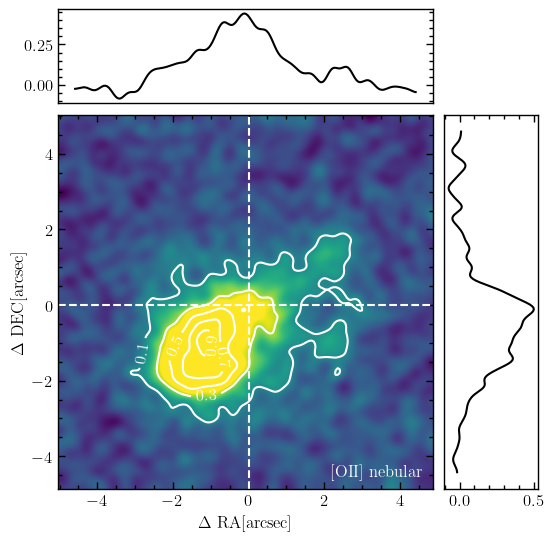

In [35]:
contours_OII = mbp.plot_intensity_map(phot, telescope_band='SUBARU_NB0718', sigma=3)

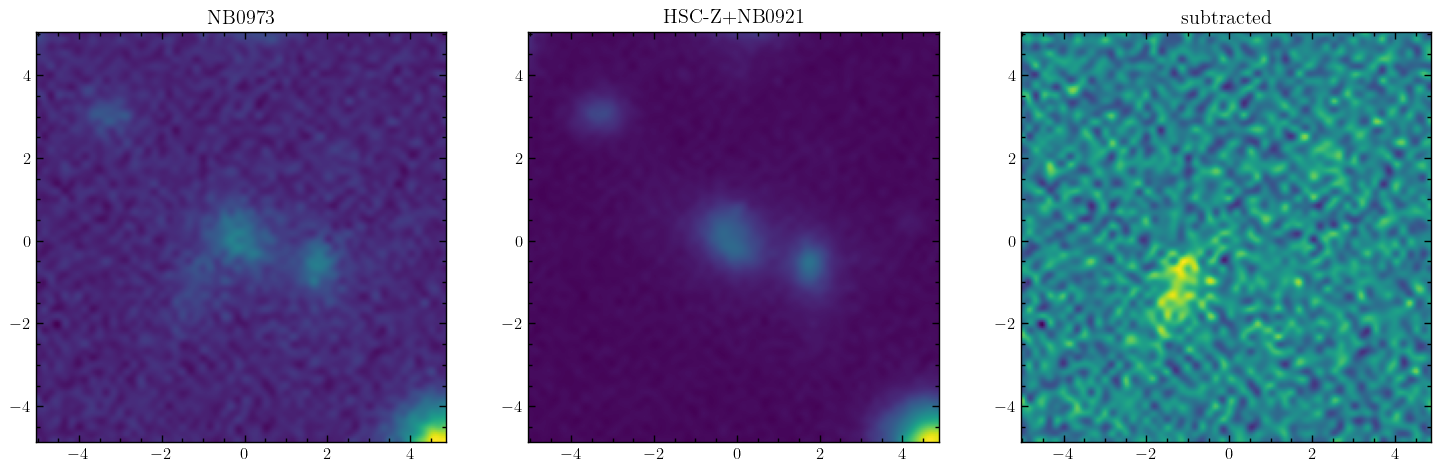

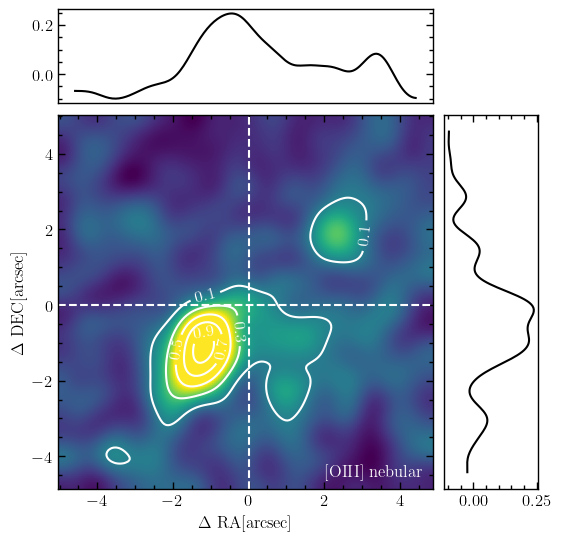

In [36]:
contours_OIII = mbp.plot_intensity_map(phot, telescope_band='SUBARU_NB0973_single', sigma=8)

HST_F606W convolved to target psf!
HST_F814W convolved to target psf!


/home/lupengjun/OII_emitter/photometry/code/multibandphotometry/photometry.py:238: RuntimeWarning: divide by zero encountered in divide
  rms_map = np.sqrt(1/rms_map) #weight map = 1/sigma***2


JWST_F115W convolved to target psf!


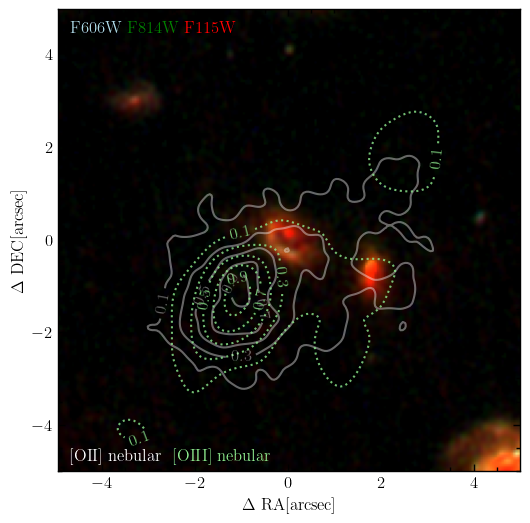

In [37]:
rgb_img = mbp.plot_rgb_image(phot, ['HST_F606W', 'HST_F814W', 'JWST_F115W'], contours_data=np.array([contours_OII, contours_OIII]), stretch=0.02, Q=1)

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.units as u
import sys
from datetime import datetime
import os
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.visualization import ZScaleInterval, ImageNormalize, make_lupton_rgb
from scipy import interpolate
from scipy import ndimage
from astropy.stats import sigma_clipped_stats
from scipy.ndimage import zoom
from astropy.convolution import convolve, convolve_fft
from matplotlib.backends.backend_pgf import FigureCanvasPgf
mpl.backend_bases.register_backend('pdf', FigureCanvasPgf)
pgf_with_latex = {
    "text.usetex": True,            # use LaTeX to write all text
    "pgf.rcfonts": False,           # Ignore Matplotlibrc
    "pgf.preamble": '\\usepackage{color}'     # xcolor for colours
}
mpl.rcParams.update(pgf_with_latex)
def plot_rgb_image(galaxy, telescope_bands, contours_data=None, size=10*u.arcsec, stretch=5, Q=8):
    '''
    Plot RGB image of the galaxy.
    '''
    datas = []
    for telescope_band in telescope_bands:
        data, header, wcs = galaxy.image_files[telescope_band], galaxy.header_files[telescope_band], galaxy.wcss[telescope_band]
        bkg_map, rms_map, source_mask = galaxy.load_background(telescope_band, regenerate=False)
        data_bkgsub = data-bkg_map
        pixelscl = wcs.proj_plane_pixel_scales()[0].to(u.arcsec).value
        #convolve to the same psf
        if galaxy.psf_homo and telescope_band.split('_')[-1]!=galaxy.psf_homo:
            kernel = galaxy.load_psf_kernel(telescope_band, galaxy.psf_homo)
            data_bkgsub = convolve_fft(data_bkgsub, kernel, normalize_kernel=True, allow_huge=True)
            print(f'{telescope_band} convolved to target psf!')
        cutout_ = Cutout2D(data_bkgsub, position=galaxy.source_position, size=size, wcs=galaxy.wcss[telescope_band])
        cutout = cutout_.data
        #resample to the same pixel scale
        if pixelscl != 0.05:
            ratio = pixelscl/0.05
            cutout = zoom(cutout, ratio)/ratio**2
        datas.append(cutout*galaxy.unit_convert(telescope_band))
        print(cutout.shape)
    datas = np.array(datas)
    print(datas.shape)
    extent = np.concatenate([((np.array(cutout_.bbox_cutout[0])-cutout_.position_cutout[0])*wcs.proj_plane_pixel_scales()[0]).to(u.arcsec).value, 
                                ((np.array(cutout_.bbox_cutout[1])-cutout_.position_cutout[1])*wcs.proj_plane_pixel_scales()[1]).to(u.arcsec).value])
    #plot
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1)
    rgb_img = make_lupton_rgb(datas[2], datas[1], datas[0], stretch=stretch, Q=Q)
    ax.imshow(rgb_img, extent=extent, origin='lower',)
    if np.any(contours_data): #draw nebular contours
        CS = ax.contour(contours_data, extent=extent, colors='white', alpha=0.6, levels=np.arange(0.1, 1, 0.2)) 
        ax.clabel(CS, levels=CS.levels)
    ax.text(0.95*extent[0], 0.95*extent[-1], telescope_bands[0].split('_')[-1], color='lightblue', ha='left', va='top', fontstyle='italic', fontweight='bold')
    ax.text(0.70*extent[0], 0.95*extent[-1], telescope_bands[1].split('_')[-1], color='g', ha='left', va='top', fontstyle='italic', fontweight='bold')
    ax.text(0.45*extent[0], 0.95*extent[-1], telescope_bands[2].split('_')[-1], color='r', ha='left', va='top', fontstyle='italic', fontweight='bold')
    ax.set_xlabel('$\Delta$ RA[arcsec]')
    ax.set_ylabel('$\Delta$ DEC[arcsec]')
    plt.savefig('_'.join(telescope_bands)+'.png')
    plt.show()

In [8]:
telescope_bands = ['HST_F606W', 'HST_F814W', 'JWST_F115W', 'JWST_F150W', 'JWST_F277W', 'JWST_F444W']

HST_F606W convolved to target psf!
HST_F814W convolved to target psf!


/home/lupengjun/OII_emitter/photometry/code/multibandphotometry/photometry.py:238: RuntimeWarning: divide by zero encountered in divide
  rms_map = np.sqrt(1/rms_map) #weight map = 1/sigma***2


JWST_F115W convolved to target psf!


/home/lupengjun/OII_emitter/photometry/code/multibandphotometry/photometry.py:238: RuntimeWarning: divide by zero encountered in divide
  rms_map = np.sqrt(1/rms_map) #weight map = 1/sigma***2


JWST_F150W convolved to target psf!


/home/lupengjun/OII_emitter/photometry/code/multibandphotometry/photometry.py:238: RuntimeWarning: divide by zero encountered in divide
  rms_map = np.sqrt(1/rms_map) #weight map = 1/sigma***2


JWST_F277W convolved to target psf!


/home/lupengjun/OII_emitter/photometry/code/multibandphotometry/photometry.py:238: RuntimeWarning: divide by zero encountered in divide
  rms_map = np.sqrt(1/rms_map) #weight map = 1/sigma***2


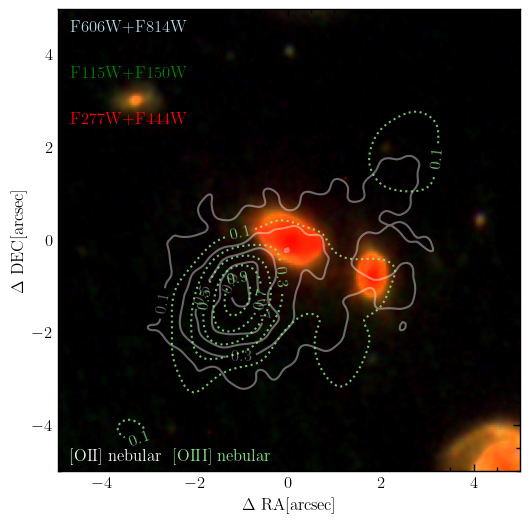

In [9]:
mbp.plot_rgb_image(phot, telescope_bands, contours_data=np.array([contours_OII, contours_OIII]), stretch=0.02, Q=1)

HST_F606W convolved to target psf!
HST_F814W convolved to target psf!


/home/lupengjun/OII_emitter/photometry/code/multibandphotometry/photometry.py:238: RuntimeWarning: divide by zero encountered in divide
  rms_map = np.sqrt(1/rms_map) #weight map = 1/sigma***2


JWST_F115W convolved to target psf!


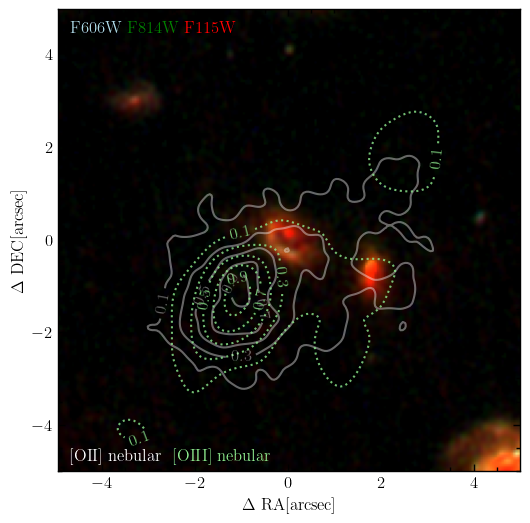

HST_F814W convolved to target psf!


/home/lupengjun/OII_emitter/photometry/code/multibandphotometry/photometry.py:238: RuntimeWarning: divide by zero encountered in divide
  rms_map = np.sqrt(1/rms_map) #weight map = 1/sigma***2


JWST_F115W convolved to target psf!


/home/lupengjun/OII_emitter/photometry/code/multibandphotometry/photometry.py:238: RuntimeWarning: divide by zero encountered in divide
  rms_map = np.sqrt(1/rms_map) #weight map = 1/sigma***2


JWST_F150W convolved to target psf!


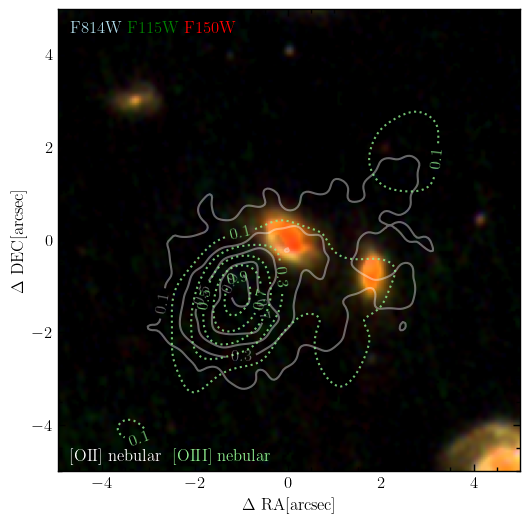

/home/lupengjun/OII_emitter/photometry/code/multibandphotometry/photometry.py:238: RuntimeWarning: divide by zero encountered in divide
  rms_map = np.sqrt(1/rms_map) #weight map = 1/sigma***2


JWST_F115W convolved to target psf!


/home/lupengjun/OII_emitter/photometry/code/multibandphotometry/photometry.py:238: RuntimeWarning: divide by zero encountered in divide
  rms_map = np.sqrt(1/rms_map) #weight map = 1/sigma***2


JWST_F150W convolved to target psf!


/home/lupengjun/OII_emitter/photometry/code/multibandphotometry/photometry.py:238: RuntimeWarning: divide by zero encountered in divide
  rms_map = np.sqrt(1/rms_map) #weight map = 1/sigma***2


JWST_F277W convolved to target psf!


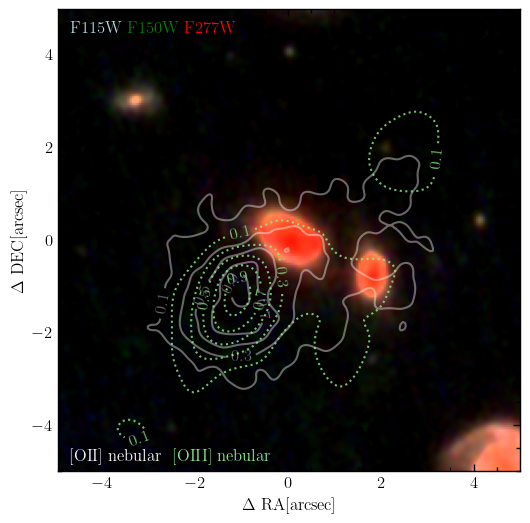

/home/lupengjun/OII_emitter/photometry/code/multibandphotometry/photometry.py:238: RuntimeWarning: divide by zero encountered in divide
  rms_map = np.sqrt(1/rms_map) #weight map = 1/sigma***2


JWST_F150W convolved to target psf!


/home/lupengjun/OII_emitter/photometry/code/multibandphotometry/photometry.py:238: RuntimeWarning: divide by zero encountered in divide
  rms_map = np.sqrt(1/rms_map) #weight map = 1/sigma***2


JWST_F277W convolved to target psf!


/home/lupengjun/OII_emitter/photometry/code/multibandphotometry/photometry.py:238: RuntimeWarning: divide by zero encountered in divide
  rms_map = np.sqrt(1/rms_map) #weight map = 1/sigma***2


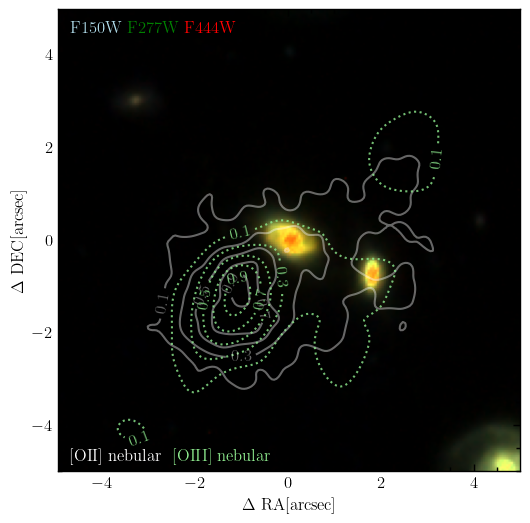

In [10]:
stretchs = [0.02, 0.02, 0.02, 0.1]
for i in range(len(telescope_bands)-2):
    telescope_band = telescope_bands[i:i+3]
    mbp.plot_rgb_image(phot, telescope_band, contours_data=np.array([contours_OII, contours_OIII]), stretch=stretchs[i], Q=1)

Text(100, 150, '$\\rm{\\uppercase\\expandafter{\\romannumeral2}}$ nebular')

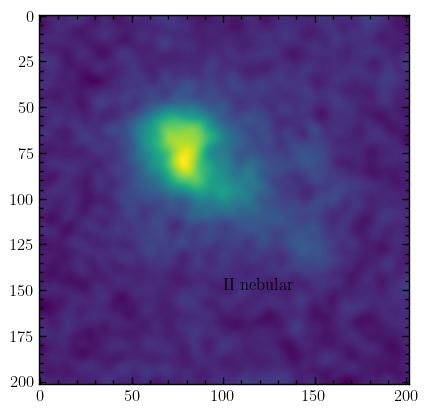

In [12]:
import matplotlib.pyplot as plt
plt.imshow(contours_OII)
plt.text(100,150,'$\\rm{\\uppercase\\expandafter{\\romannumeral2}}$ nebular')

## Make a rgb image combined with radio continuum

In [33]:
size = 10*u.arcsec
header_ = fits.getheader('/home/lupengjun/OII_emitter/data/VLA_3GHz/CWebOII-vla_3ghz_msmf.fits')
header = header_.copy()
for keyword in header_:
    if not keyword.startswith('C') or keyword.endswith('3') or keyword.endswith('4'):
        del header[keyword]


KeyError: "Keyword 'HISTORY' not found."

HST_F606W convolved to target psf!
HST_F814W convolved to target psf!


/home/lupengjun/OII_emitter/photometry/code/multibandphotometry/photometry.py:238: RuntimeWarning: divide by zero encountered in divide
  rms_map = np.sqrt(1/rms_map) #weight map = 1/sigma***2


JWST_F115W convolved to target psf!


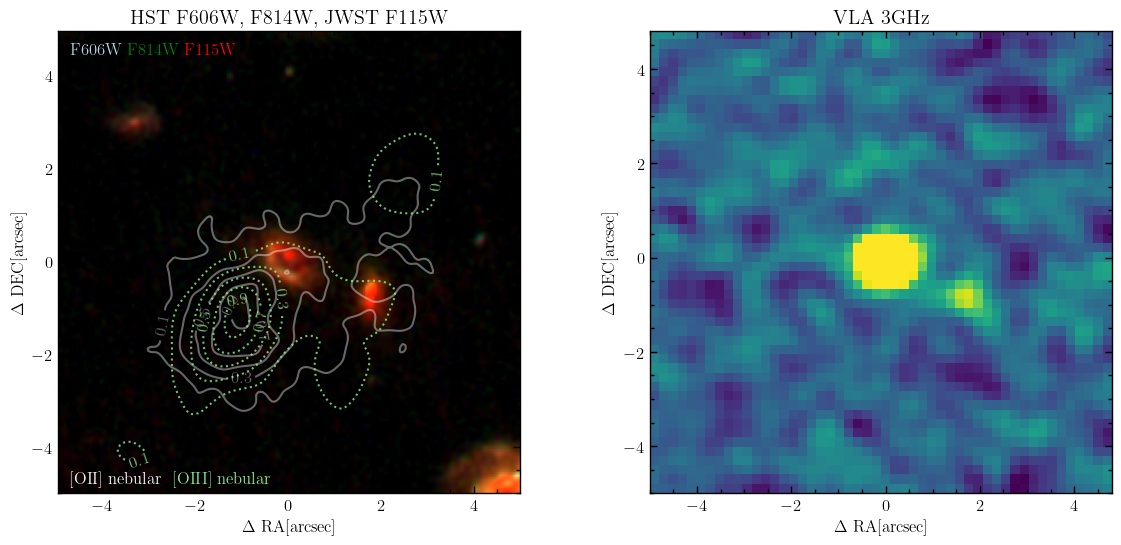

In [43]:
wcs = WCS(header)
data = fits.getdata('/home/lupengjun/OII_emitter/data/VLA_3GHz/CWebOII-vla_3ghz_msmf.fits')
cutout = Cutout2D(data, position=phot.source_position, size=size, wcs=wcs)
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,2,1)
mbp.plot_rgb_image(phot, ['HST_F606W', 'HST_F814W', 'JWST_F115W'], contours_data=np.array([contours_OII, contours_OIII]), stretch=0.02, Q=1, ax=ax)
ax.set_title('HST F606W, F814W, JWST F115W')
ax = fig.add_subplot(1,2,2)
extent = np.concatenate([((np.array(cutout.bbox_cutout[0])-cutout.position_cutout[0])*wcs.proj_plane_pixel_scales()[0]).to(u.arcsec).value, 
                        ((np.array(cutout.bbox_cutout[1])-cutout.position_cutout[1])*wcs.proj_plane_pixel_scales()[1]).to(u.arcsec).value])
norm = ImageNormalize(cutout.data, interval=ZScaleInterval())
ax.imshow(cutout.data, norm=norm, extent=extent, origin='lower')
ax.set_xlabel('$\Delta$ RA[arcsec]')
ax.set_ylabel('$\Delta$ DEC[arcsec]')
ax.set_title('VLA 3GHz')
plt.show()

# Fit a guassian beam shape to check the point source

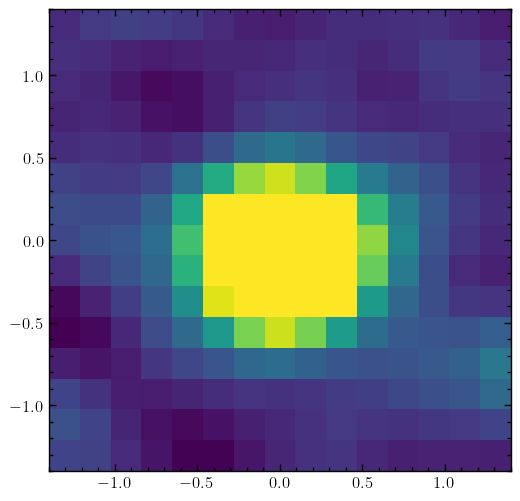

In [95]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
# cutout = Cutout2D(data, position=phot.source_position, size=3*u.arcsec, wcs=wcs)
extent = np.concatenate([((np.array(cutout.bbox_cutout[0])-cutout.position_cutout[0])*wcs.proj_plane_pixel_scales()[0]).to(u.arcsec).value, 
                        ((np.array(cutout.bbox_cutout[1])-cutout.position_cutout[1])*wcs.proj_plane_pixel_scales()[1]).to(u.arcsec).value])
norm = ImageNormalize(cutout.data, interval=ZScaleInterval())
ax.imshow(cutout.data, norm=norm, extent=extent, origin='lower')

In [76]:
from astropy.modeling import models, fitting
from astropy.stats import sigma_clip, sigma_clipped_stats
FWHM = 0.75*u.arcsec #arcsec
pix_scale = wcs.proj_plane_pixel_scales()[0].to(u.arcsec)
x_stddev, y_stddev = (FWHM/pix_scale).value/2/np.sqrt(2*np.log(2)), (FWHM/pix_scale).value/2/np.sqrt(2*np.log(2))
y, x = np.mgrid[:cutout.data.shape[0], :cutout.data.shape[1]]

In [127]:
g_init = models.Gaussian2D(amplitude=1., x_mean=cutout.data.shape[0]/2-1, y_mean=cutout.data.shape[1]/2-1, x_stddev=x_stddev, y_stddev=y_stddev, theta=0)
g_init.x_stddev.fixed = False
g_init.y_stddev.fixed = False
g_init.theta.fixed = True
fit_g = fitting.LevMarLSQFitter()
bkg_median = sigma_clipped_stats(cutout.data, sigma=3, maxiters=5)[1]
norm_data = (cutout.data-bkg_median)/np.max(cutout.data-bkg_median)
g = fit_g(g_init, x, y, norm_data)
g

<Gaussian2D(amplitude=1.03426003, x_mean=7.06600413, y_mean=6.53513729, x_stddev=1.81585399, y_stddev=1.61525384, theta=0.)>

In [131]:
g.x_stddev.value*2*np.sqrt(2*np.log(2))*pix_scale, g.y_stddev.value*2*np.sqrt(2*np.log(2))*pix_scale

(<Quantity 0.85520188 arcsec>, <Quantity 0.76072643 arcsec>)

In [110]:
def profile_2D(data, mode='mean'):
    nx, ny = data.shape
    if mode == 'mean':
        x_marg = [np.mean(data[i, :]) for i in range(data.shape[0])]
        y_marg = [np.mean(data[:, j]) for j in range(data.shape[1])]
    # elif mode == 'sum':
    #     x_marg = [np.sum(data[i, :]) for i in range(data.shape[0])]
    #     y_marg = [np.sum(data[:, j]) for j in range(data.shape[1])]
    #     x_marg = np.array(x_marg)/np.max(x_marg)
    #     y_marg = np.array(y_marg)/np.max(y_marg)
    elif mode == 'cut':
        if nx%2 == 0: x_marg = data[(nx//2-1):(nx//2+1)].mean(axis=0)
        else: x_marg = data[nx//2]
        if ny%2 == 0: y_marg = data[:, (ny//2-1):(ny//2+1)].mean(axis=1)
        else: y_marg = data[:, ny//2]
    return np.array(x_marg), np.array(y_marg)

In [107]:
def plot_img_profile(img, model, extent, mode='mean'):
    fig = plt.figure(figsize=(6, 6))
    gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                    left=0.1, right=0.9, bottom=0.1, top=0.9,
                    wspace=0.05, hspace=0.05)
    ax_img = fig.add_subplot(gs[1, 0])
    ax_x = fig.add_subplot(gs[0, 0])
    ax_y = fig.add_subplot(gs[1, 1])
    norm = ImageNormalize(img, interval=ZScaleInterval())
    # ax_img.imshow(img, norm=norm, extent=extent, origin='lower')
    ax_img.imshow(img, extent=extent, origin='lower')
    xmin, xmax = ax_img.get_xlim()
    ymin, ymax = ax_img.get_ylim() 
    ax_img.set_xlabel('$\Delta$ RA[arcsec]')
    ax_img.set_ylabel('$\Delta$ DEC[arcsec]')
    ax_img.text(0.95*xmax, 0.95*ymin, 'VLA 3GHz', color='white', ha='right', va='bottom', fontstyle='italic', fontweight='bold')
    array_x_data, array_y_data = profile_2D(img, mode=mode)
    array_x_model, array_y_model = profile_2D(model, mode=mode)
    array_x_res, array_y_res = profile_2D(img-model, mode=mode)
    ax_x.plot(array_x_data, 'b-', label='data')
    ax_x.plot(array_x_model, 'r--', label='model')
    ax_x.plot(array_x_res, 'k-', label='residual')
    ax_x.set_xticks([])
    ax_x.legend()
    ax_y.plot(array_y_data, np.arange(len(array_y_data)), 'b-', label='data')
    ax_y.plot(array_y_model, np.arange(len(array_y_model)), 'r--', label='model')
    ax_y.plot(array_y_res, np.arange(len(array_y_res)), 'k-', label='residual')
    ax_y.set_yticks([])


Text(0.5, 1.0, 'Residual')

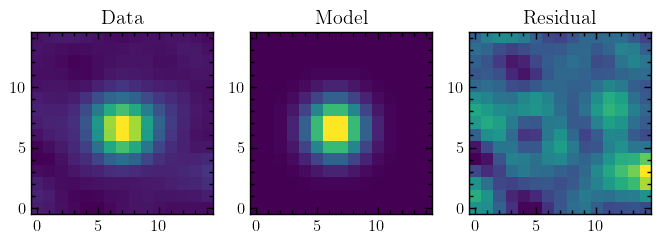

In [128]:
norm = ImageNormalize(norm_data, interval=ZScaleInterval())
plt.figure(figsize=(8, 2.5))
plt.subplot(1, 3, 1)
plt.imshow(norm_data, origin='lower', interpolation='nearest',)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(g_init(x, y), origin='lower', interpolation='nearest',)
plt.title("Model")
plt.subplot(1, 3, 3)
plt.imshow(norm_data - g(x, y), origin='lower', interpolation='nearest',)
plt.title("Residual")

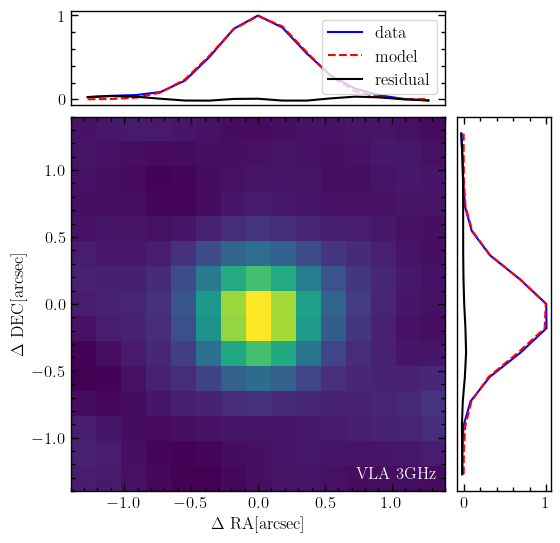

In [129]:
plot_img_profile(norm_data, g(x, y), extent, mode='cut')

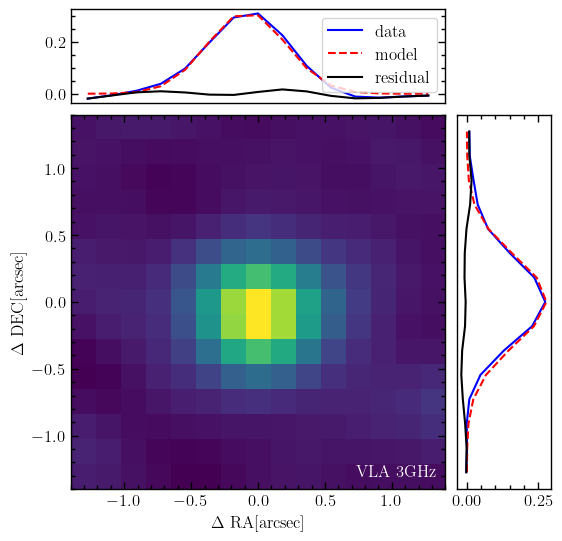

In [130]:
plot_img_profile(norm_data, g(x, y), extent, mode='mean')

In [134]:
from astropy.convolution import convolve_models
g1 = models.Gaussian1D(1, -1, 1)
g2 = models.Gaussian1D(1, 1, 1)
g3 = convolve_models(g1, g2)

In [139]:
g1.stddev.value, g2.stddev.value

(1.0, 1.0)

In [132]:
from scipy import signal
original = norm_data
impulse_response = [[2, 1],[2,1]]
recorded = signal.convolve(impulse_response, original)
recorded
recovered, remainder = signal.deconvolve(recorded, impulse_response)
recovered

ValueError: signal must be 1-D.

# delayed_tau SFH

In [2]:
def delayed_tau_SFH(t, t0, tau):
    '''
    Delayed tau star formation history.
    '''
    t_mask = t<t0
    SFH = np.zeros_like(t)
    SFH[t_mask] = (t0-t[t_mask])*np.exp(-(t0-t[t_mask])/tau)
    return SFH
# age = param["age"]*10**9
# tau = param["tau"]*10**9
# t = age - self.ages[self.ages < age]

# sfr[self.ages < age] = t*np.exp(-t/tau)


Text(0, 0.5, 'SFR')

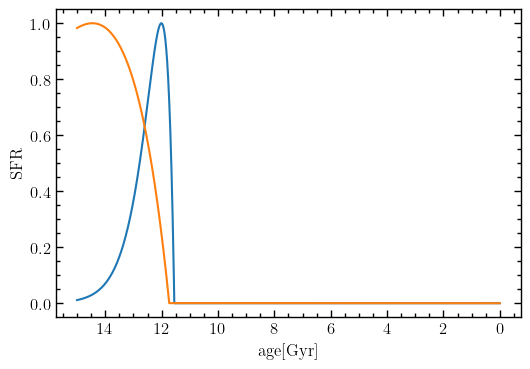

In [11]:
t = np.linspace(15, 0, 100000)
SFH1 = delayed_tau_SFH(t, 3+0.45, 0.46)
SFH2 = delayed_tau_SFH(t, 3+0.27, 2.73)
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(15-t, SFH1/np.max(SFH1))
ax.plot(15-t, SFH2/np.max(SFH2))
# ax.set_xlim(13,16)
ax.invert_xaxis()
ax.set_xlabel('age[Gyr]')
ax.set_ylabel('SFR')